In [1]:
import os

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader

import feature_extractor as f_extr
import unet_dataset as unet_ds
import plots
import metrics

# 1. Dataset

In [ ]:
!unzip ./final_dataset_big.zip

In [2]:
!ls train/images | wc
!ls train/labels | wc

!ls test/images | wc
!ls test/labels | wc

    300     300   14534
    300     300   14534
     32      32    1499
     32      32    1499


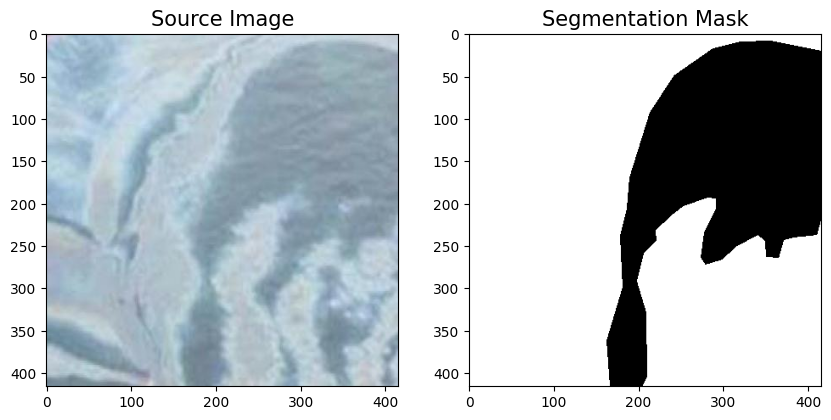

In [3]:
img_p = 'train/images/0_jpg.rf.56a482af2af9b4c9402be700d520f670.jpg'
lbl_p = 'train/labels/0_jpg.rf.56a482af2af9b4c9402be700d520f670.txt'

plots.show_img_lbl(img_p, lbl_p)

In [4]:
# train:
train_imgs_path = 'train/images'
train_masks_path = 'train/labels'
# train dataset:
train_dataset = unet_ds.UNetDataSet(train_imgs_path, train_masks_path)
print('test size:', len(train_dataset))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)

# test paths:
test_imgs_path = 'test/images'
test_masks_path = 'test/labels'
# test dataset:
test_dataset = unet_ds.UNetDataSet(test_imgs_path, test_masks_path)
print('test size:', len(test_dataset))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

test size: 300
test size: 32


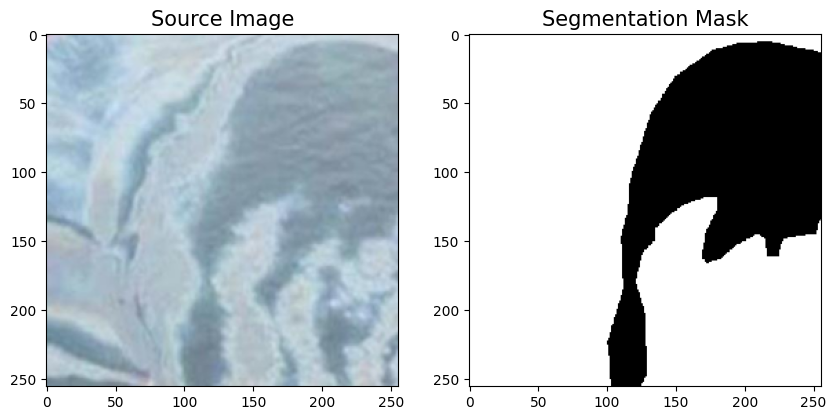

In [10]:
img_tens, lbl_tens = train_dataset[0]
plots.plot_ds_tens(img_tens, lbl_tens)

# 2. Model

Возьмем предобученную модель и дообучим ее на наши данные.

In [11]:
unet_model = torch.hub.load(
    'mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True
)

Using cache found in /root/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


## 2.1. Train

В качестве функии потерь возьмем `BinaryCrossEntropy`, а в качестве оптимизатора - `Adam` со стандартными параметрами.

In [12]:
optimizer = torch.optim.AdamW(unet_model.parameters(), lr=0.001)
bce_loss = torch.nn.BCELoss()

call_back = unet_ds.CallBack(test_loader, bce_loss)

model_trainer = unet_ds.ModelTrainer(
    unet_model,
    optimizer=optimizer,
    loss_function=bce_loss,
    callback=call_back
)

Измерим среднее IoU на тестовом датасете до обучения:

In [13]:
unet_model = unet_model.to('cuda')

In [50]:
metrics.eval_iou_over_dataset(test_loader, unet_model)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.3701, device='cuda:0')

Обучим модель:

In [56]:
model_trainer.train_model(train_loader, epochs=30)

epoch:   0%|          | 0/30 [00:00<?, ?it/s]

---------------
epoch: 151
train: 0.161
test: 1.917
---------------
epoch: 152
train: 0.151
test: 1.674
---------------
epoch: 153
train: 0.16
test: 1.554
---------------
epoch: 154
train: 0.153
test: 1.726
---------------
epoch: 155
train: 0.156
test: 1.467
---------------
epoch: 156
train: 0.151
test: 1.755
---------------
epoch: 157
train: 0.137
test: 1.831
---------------
epoch: 158
train: 0.132
test: 1.838
---------------
epoch: 159
train: 0.131
test: 1.589
---------------
epoch: 160
train: 0.13
test: 1.705
---------------
epoch: 161
train: 0.115
test: 1.615
---------------
epoch: 162
train: 0.107
test: 1.719
---------------
epoch: 163
train: 0.104
test: 1.811
---------------
epoch: 164
train: 0.102
test: 1.705
---------------
epoch: 165
train: 0.101
test: 1.821
---------------
epoch: 166
train: 0.1
test: 1.895
---------------
epoch: 167
train: 0.103
test: 1.821
---------------
epoch: 168
train: 0.105
test: 1.824
---------------
epoch: 169
train: 0.105
test: 2.089
---------------


Измерим качество после обучения:

In [62]:
metrics.eval_iou_over_dataset(test_loader, unet_model)

  0%|          | 0/1 [00:00<?, ?it/s]

tensor(0.4234, device='cuda:0')

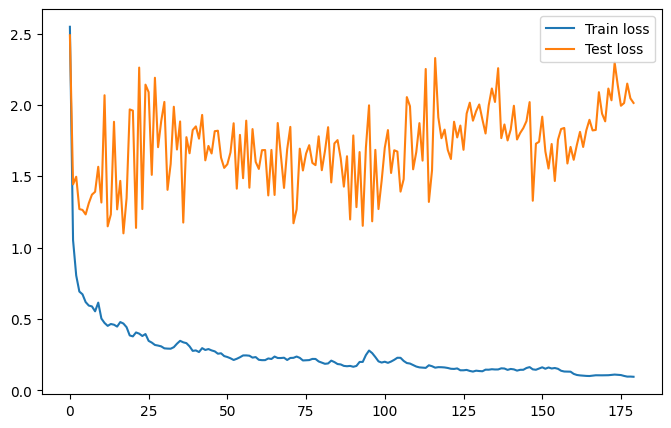

In [60]:
call_back.plot_losses()

In [42]:
# torch.save(unet_model.state_dict(), './unet_weights_big_0.pt')

In [61]:
unet_model.load_state_dict(torch.load('./unet_weights_big_042.pt'))

<All keys matched successfully>

## 2.2. Testing

train / test datasets

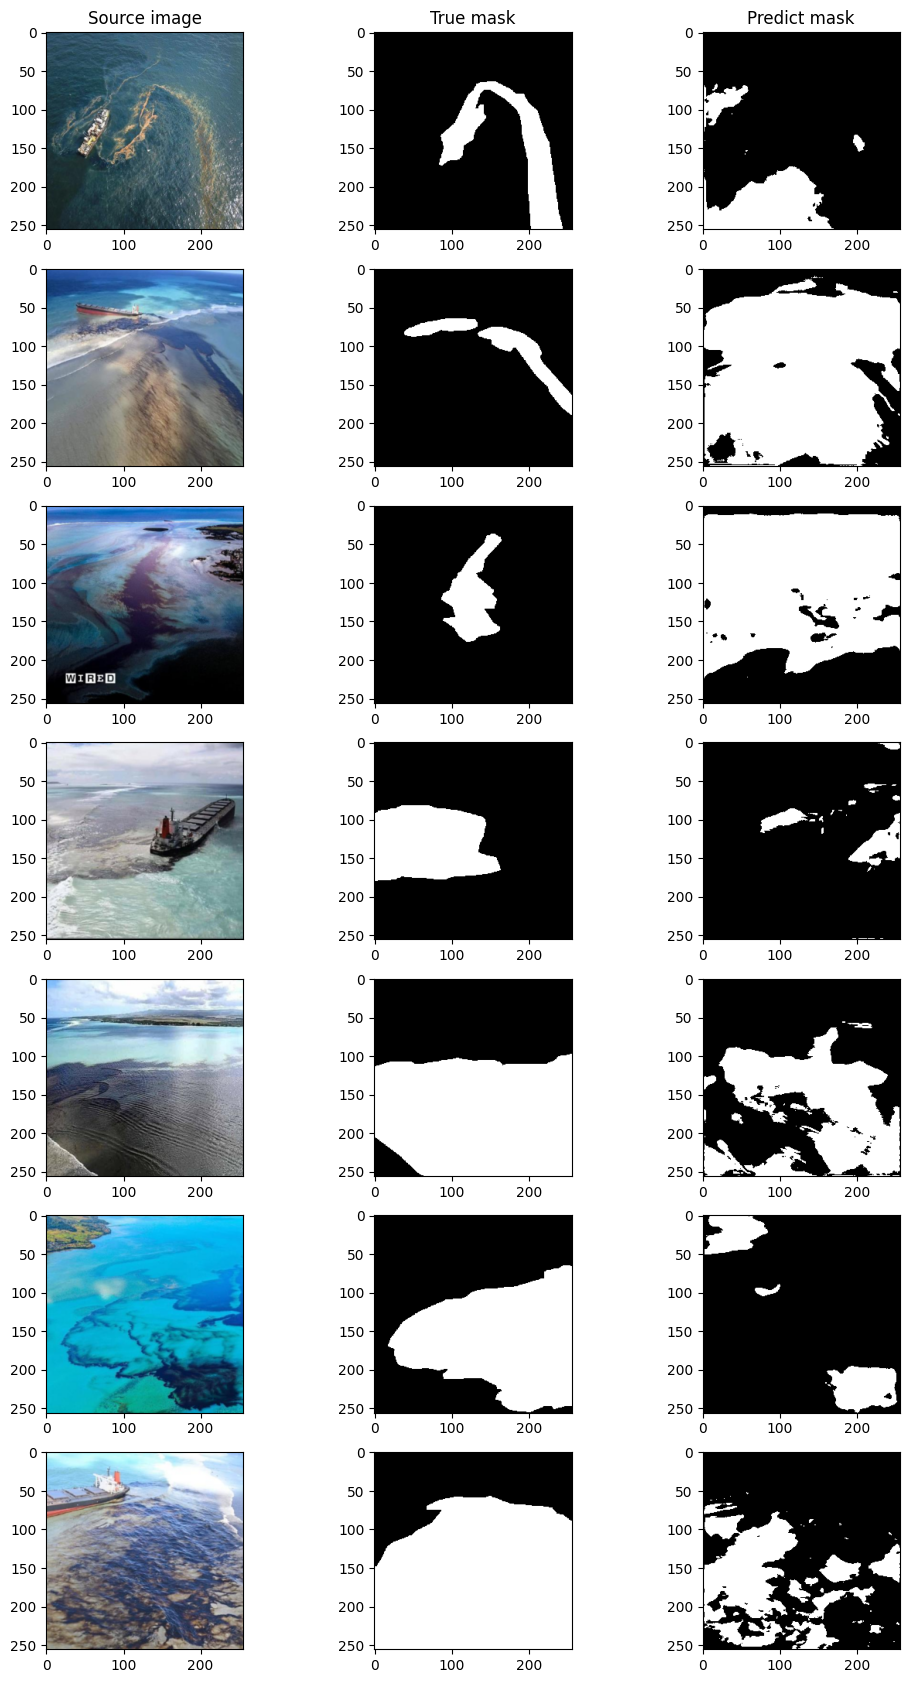

In [67]:
TEST_IMAGES_IDS = range(7)
plots.plot_examples_predict(
   unet_model, test_dataset, TEST_IMAGES_IDS, save_name='test.png'
)

In [68]:
TRAIN_IMAGES_IDS = range(30, 50)
plots.plot_examples_predict(
    unet_model, train_dataset, TRAIN_IMAGES_IDS, save_name='train.png'
)

Output hidden; open in https://colab.research.google.com to view.

test image

In [65]:
test_img = Image.open('./test_image.jpg')
test_img_tens = test_dataset.transform(test_img).unsqueeze(0)
test_img_tens.shape

torch.Size([1, 3, 256, 256])

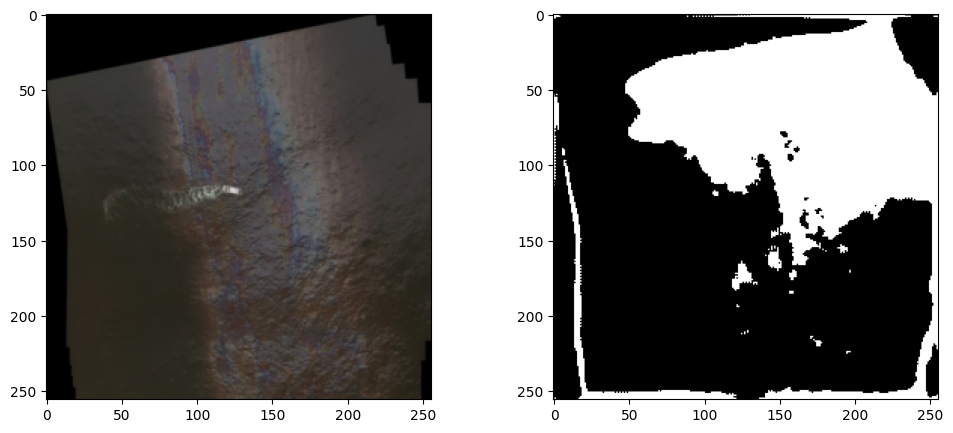

In [66]:
with torch.no_grad():
    pred_mask = (unet_model(test_img_tens.to('cuda')) > 0.5).float()

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].imshow(test_img_tens.squeeze().numpy().transpose(1, 2, 0))
ax[1].imshow(pred_mask.cpu().squeeze().numpy(), 'gray')
plt.show()